<div style="text-align: right"><strong>Capstone #3:</strong> <span style="color:darkred">Supervised Learning</span> </div>

<a id="top"></a>

###### </span>__Part 1:__ Exploration https://github.com/kimrharper/thinkful/blob/master/unit3/unit3-capstone-exploration.ipynb </span><br><span>__Part 2:__ Analysis https://github.com/kimrharper/thinkful/blob/master/unit3/unit3-capstone-analysis.ipynb </span><br><span>__Part 3:__ Models https://github.com/kimrharper/thinkful/blob/master/unit3/unit3-capstone-models.ipynb </span>

----

# <span style="color:darkred">L1 Prediction from ELL Writing Samples</span>

### <span style="color:darkred">Part 2: </span><span style="color:darkblue">Analysis</span>

__Author:__ Ryan Harper 

----

<a href='#ov'>Overview</a><br>
<a href='#exp'>Experiment</a><br>
<a href='#sec1'>1. Cleaning Data</a><br>
<a href='#sec2'>2. Exploring the Data</a><br>

<a id="ov"></a>

<a id="sec1"></a>

In [1]:
# iPython/Jupyter Notebook
import time
from pprint import pprint
import warnings
from IPython.display import Image

# Data processing
import scipy
import pandas as pd
import plotly as plo
import numpy as np
import seaborn as sns
from collections import Counter
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Statistics
from scipy import stats
from statsmodels import robust
from scipy.stats import ttest_ind, mannwhitneyu, median_test, f_oneway,mood, shapiro

# NLP
import textblob
from nltk.corpus import stopwords as sw
from nltk.util import ngrams
from nltk.corpus import brown
import nltk
import re
from nltk.tokenize import RegexpTokenizer
import difflib
from string import punctuation

# import altair as alt

In [2]:
# Jupyter Settings and Imports
%pylab
%matplotlib inline 
warnings.filterwarnings(action='once')

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


<a id="sec3"></a>

###  <span style="color:darkblue">1. Looking at Language Samples <a href='#top'>(top)</a>

In [3]:
loadDF = False
if loadDF:
    features = pd.read_csv('blogfeatures.csv').sample(frac=1.0)
else:
    %store -r blog
    features = blog
    lang = list(features.language.unique())

__Create Analysis Set__

In [4]:
languagesDF = pd.DataFrame(index=['Traditional Chinese','Japanese','CCount','JCount'],columns=['NA'])
binary = features
nonbinary = ['language','Unnamed: 0','id','pos','pos1','pos2','pos3','tokens','content','letters_per','wc','sc','sent_pol','sent_subj','cap_let','punc_count','freq_score','full_freq_score']
for b in binary.columns:
    if b not in nonbinary:
        binary[b] = binary[b].apply(lambda val: 0 if val == 0 else 1)
        ll = []
        for l in lang:
            ll.append(binary[b][binary['language'] == l].sum()/binary.language[binary['language'] == l].count())
        for l in lang:
            ll.append(int(binary[b][binary['language'] == l].sum()))
        languagesDF[b] = ll
        
del languagesDF['NA']
langDF = languagesDF.iloc[0:2].reset_index()
languagesDF

,prp_i,prp_it,prp_he,prp_you,prp_they,prp_we,prp_she,prp_me,prp_them,prp_him,...,pos1_EX,pos1_NNPS,pos1_JJ,pos1_PRP$,pos1_DT,pos1_POS,pos1_WP$,pos1_PDT,pos1_NNS,pos1_NN
Traditional Chinese,0.888171,0.64074,0.139419,0.378926,0.188436,0.285295,0.099208,0.471382,0.151159,0.071617,...,0.243910,0.030819,0.968594,0.813619,0.960669,0.208101,0.005870,0.095979,0.835045,0.990901
Japanese,0.937081,0.67932,0.136640,0.361263,0.192219,0.240143,0.093855,0.346057,0.155935,0.067953,...,0.222211,0.026741,0.974727,0.752727,0.949979,0.213612,0.007026,0.048867,0.819002,0.996330
CCount,3026.000000,2183.00000,475.000000,1291.000000,642.000000,972.000000,338.000000,1606.000000,515.000000,244.000000,...,831.000000,105.000000,3300.000000,2772.000000,3273.000000,709.000000,20.000000,327.000000,2845.000000,3376.000000
JCount,8936.000000,6478.00000,1303.000000,3445.000000,1833.000000,2290.000000,895.000000,3300.000000,1487.000000,648.000000,...,2119.000000,255.000000,9295.000000,7178.000000,9059.000000,2037.000000,67.000000,466.000000,7810.000000,9501.000000


In [5]:
binary['cuw_god'][binary['language']=='Traditional Chinese'].sum()/(binary.language[binary['language'] == 'Traditional Chinese']).count()

0.03668916935720575

In [6]:
languagesDF['cuw_god']

Traditional Chinese      0.036689
Japanese                 0.008809
CCount                 125.000000
JCount                  84.000000
Name: cuw_god, dtype: float64

In [7]:
def check_differences(s):
    a = s.iloc[0]
    b = s.iloc[1]
    top = abs(a-b)
    bot = (a+b)/2
    perc_diff = top/bot
    return perc_diff

def graph_vis(f,bool):
    if bool:
        sns.factorplot(data=langDF, x='index', y=f, kind='bar')
        plt.title('% of {}'.format(f))
        blue_patch = mpatches.Patch(color='steelblue', label='# of Chinese: {}'.format(languagesDF[f].iloc[2]))
        orange_patch = mpatches.Patch(color='darkorange', label='# of Japanese: {}'.format(languagesDF[f].iloc[3]))
        plt.legend(handles=[blue_patch,orange_patch])

In [8]:
languagesDF['adv_still'].iloc[3]

616.0

In [9]:
from scipy.stats import binom_test

keepfeatures = []
for feat in list(languagesDF.columns):
    if feat != 'language':
        
        if (check_differences(languagesDF[feat]) > .4) and languagesDF[feat].sum()>50:
#             graph_vis(feat,True)
            keepfeatures.append(feat)       
plt.show()
%store keepfeatures

Stored 'keepfeatures' (list)


In [1]:
len(keepfeatures)

NameError: name 'keepfeatures' is not defined

__Reject Outliers__

In [11]:
def MEDIAN_reject_outliers(data, m=3):
    data = data[abs(data - np.median(data)) < m*robust.mad(data)]
    return data[~np.isnan(data)].sort_values()


def MEAN_reject_outliers(data, m=3):
    data = data[abs(data - np.mean(data)) < m*np.std(data)]
    return data[~np.isnan(data)].sort_values()

__Create Analysis DF__

In [12]:
analysis_features=['letters_per','wc','sc','sent_pol','sent_subj','cap_let','punc_count','full_freq_score']
blog_features =['language']
full_features = analysis_features + blog_features
analysis = features[full_features]

__Plot Hist__

_Decision Tree Truncated SVD Features_

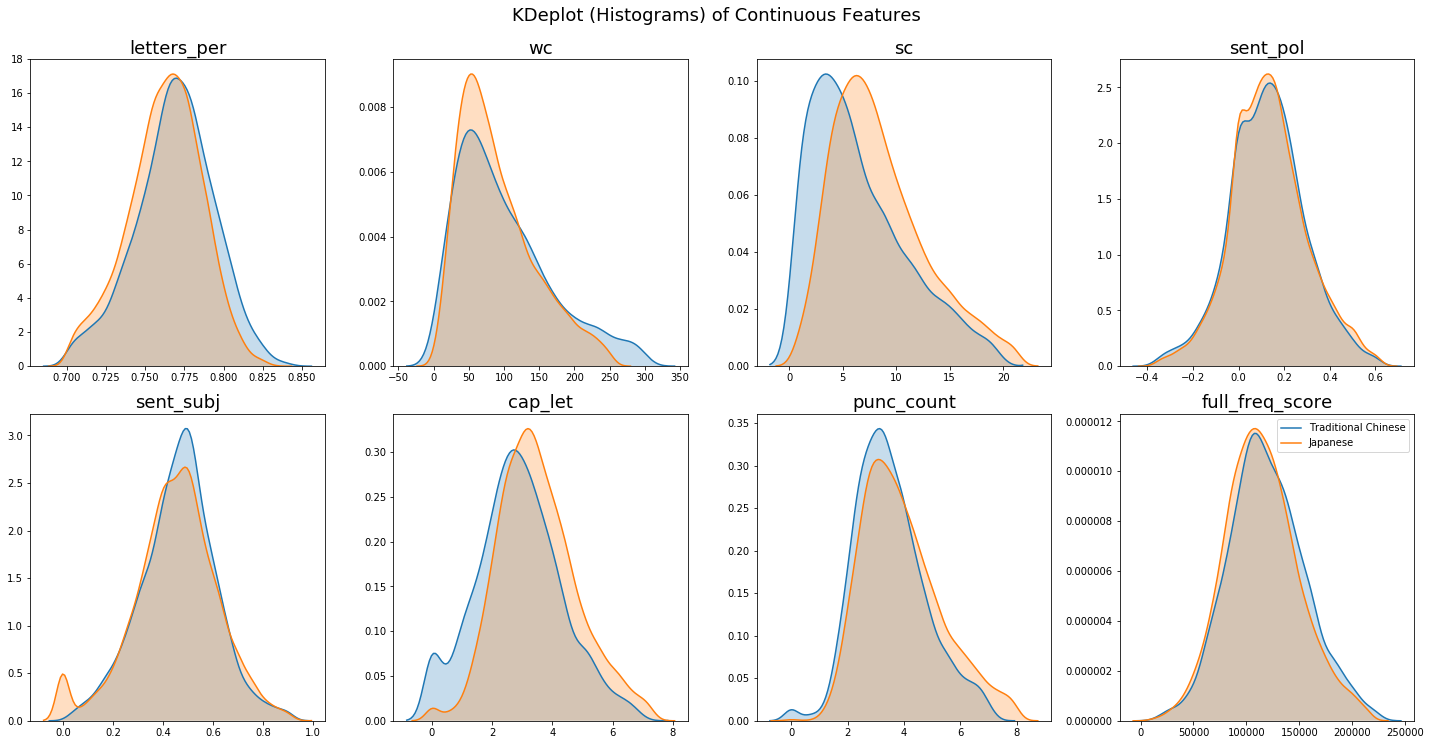

In [13]:
i = 1
fig=plt.figure(figsize=(20,10))
for feat in analysis_features:
    if feat != 'language':
        plt.subplot(2, 4, i)
        i = i + 1
        langfeats = [MEDIAN_reject_outliers(analysis[feat][analysis.language == l]) for l in lang]
        for g in langfeats:
            sns.kdeplot(g,legend=None,kernel='gau',shade=True,)
            plt.title(feat, fontsize=18)

fig.suptitle('KDeplot (Histograms) of Continuous Features', fontsize=18, y=1.03)
plt.tight_layout()
plt.legend(lang)
plt.show()

In [14]:
from scipy.stats import ttest_ind

for c in analysis_features:
    g = [(blog[c][blog.language == l]) for l in lang]
    stat,p = ttest_ind(g[0],g[1])

    if (p < .05) & (p > 0):
        print('{}:\x1b[92m{}\x1b[0m'.format(c,p))
    elif p > .05:
        print('{}:\x1b[31m{}\x1b[0m'.format(c,p))
    else:
        print('{}:\x1b[33m{}\x1b[0m'.format(c,p))

letters_per:3.658300613614781e-39
wc:6.378157218238824e-14
sc:6.100618488069283e-09
sent_pol:0.004090030379914499
sent_subj:0.48504616386813104
cap_let:1.2756773756042557e-67
punc_count:1.6397855918587436e-33
full_freq_score:1.882342916446436e-11


__Correlations (of top features by decision tree importance)__

In [15]:
%store -r bnb_sorted

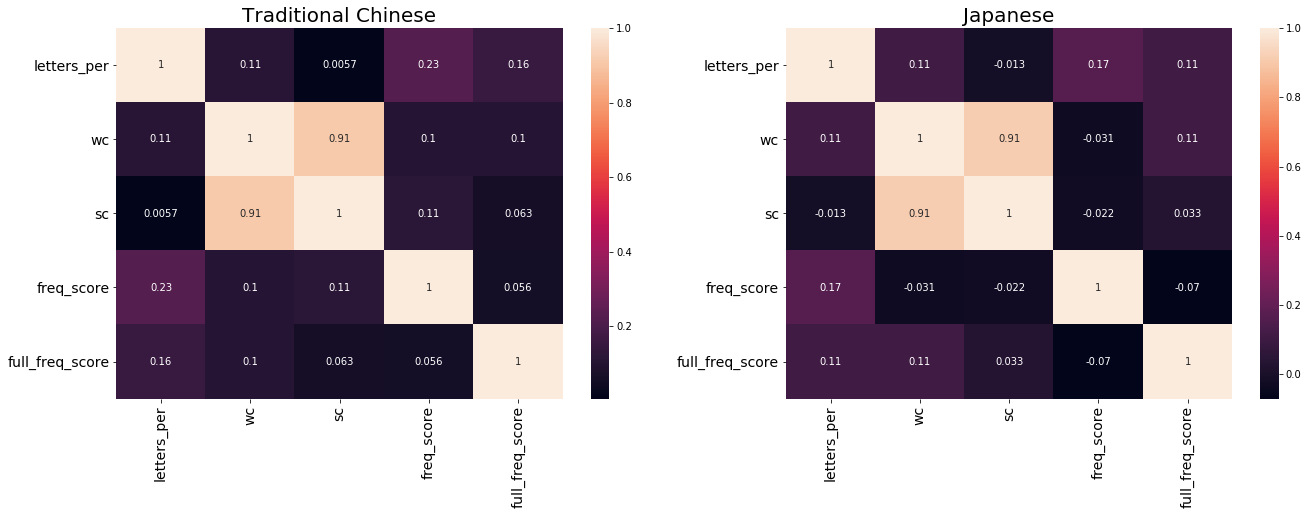

In [16]:
# corr = analysis.corr(); print(corr)
i = 1
fig=plt.figure(figsize=(22,15))

for ind,g in enumerate([(features[bnb_sorted[0:5]][features.language == l]) for l in lang]):
    plt.subplot(2, 2, i)
    i = i + 1
    
    corr = g.corr()
    sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            annot=True)
    plt.title(lang[ind],fontsize = 20)
    plt.xticks(rotation='vertical',fontsize = 14)
    plt.yticks(rotation='horizontal',fontsize = 14)
    
plt.show()

<a id="sec3"></a>

###  <span style="color:darkblue">C. Statistical Significance <a href='#top'>(top)</a>

In [17]:
from scipy.stats import median_test
from statsmodels.stats.proportion import proportions_ztest

def mw_test(a,b):
    stat,p = mannwhitneyu(a,b, use_continuity=True, alternative=None)
    return stat,p

def moods_median_test(a,b,c,d):
    stat, p, med, tbl = median_test(a,b,c,d)
    return stat,p

def f1way_test(a,b,c,d):
    f,b = f_oneway(a,b,c,d)
    return f,b

import warnings
warnings.filterwarnings('ignore')

__Proportion Z-Test:__

In [18]:
CLen = len(features[features.language =='Traditional Chinese'])
JLen = len(features[features.language =='Traditional Chinese'])

for feat in keepfeatures[0:20]:
    CCount = languagesDF[feat].iloc[2]
    JCount = languagesDF[feat].iloc[3]
    counts = np.array([CCount,JCount])
    nobs = np.array([CLen,JLen])
    stat, p = proportions_ztest(counts, nobs)
    
    if (p < .05) & (p > 0):
        print('{}:\x1b[92m{}\x1b[0m'.format(feat,p),end='|')
    elif p > .05:
        print('{}:\x1b[31m{}\x1b[0m'.format(feat,p),end='|')
    else:
        print('{}:\x1b[33m{}\x1b[0m'.format(feat,p),end='|')
    

prp_us:2.1727948710394688e-13|prp_themselves:0.26859516439037034|prp_myself:2.227770490101894e-06|prp_herself:0.031798833029012236|prp_yourself:0.30901526618045183|prp_ourselves:0.12607830691962182|cc_yet:4.180954285713628e-30|prep_along:0.03986536843870174|prep_across:0.025983670860614816|prep_de:2.5725226517465718e-08|prep_behind:0.06702703872349279|prep_toward:1.340885251376464e-07|prep_near:2.258662335643635e-51|prep_unless:0.0262255204655606|prep_past:0.06818855261481119|prep_far:2.8870145644730413e-05|adv_just:1.3914137330310227e-15|adv_here:7.719205896364638e-29|adv_still:1.60873401994528e-06|adv_always:1.22480365668219e-12|

__Mann Whitney U test (2 Non-Normally Distributed Independent Samples)__

__B. Mood’s Median test (2+ Non-Normally Distributed Independent Samples)__

__Null Hypothesis:__ Assumes samples are from same 1st language population.

__B. One-Way AnovaTest (2+ Normally Distributed Independent Samples)__

__Null Hypothesis:__ Assumes samples are from same 1st language population.